In [1]:
from pymongo import MongoClient
import pandas as pd
import numpy as np

import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
import re
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%config InlineBackend.figure_format = 'retina'

import hdbscan
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertModel, BertConfig, BertTokenizer
from tqdm.notebook import tqdm as tqdm
import umap
from bertopic import BERTopic

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly

import glob
import pathlib

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1076)>


## Data description
The data was retrieved from VK.com using VK API. 
These are the methods used for data pursuit
- groups.search (https://vk.com/dev/groups.search) - enables you to get the results of group search using some query
- wall.get (https://vk.com/dev/wall.get) enables you to get posts of a community or a person
- groups.getMembers (https://vk.com/dev/groups.getMembers) is used to get members ids. However, you cannot get more than 1000 followers ids

The data are the Russian texts of 100 posts per the community (posts are joined in one text per group). The groups were taken using 3 search queries: music, science, books. We have taken the first 300 groups per category (default vk sorting).

Regarding the process of cleaning data, there were lots of words and signs to remove. The posts were chosen the way that they are created only by the group itself, so the topics are rather consistent with the search query.


In [2]:
data = pd.concat(map(pd.read_csv, glob.glob('data/*.csv')))

In [3]:
data['post_length'] = data.text.apply(len)
data = data[data['post_length'] > 100]
posts = data.text

# Text preprocessing + TD-IDF + K-Means

## Text Preprocessing

Tokenization is the process  by which we break down posts into individual sentences or words, as needed. Besides just splitting the text into words we also perform additional filtration, for example, we remove tokens which are entirely numeric values or punctuation, tags, unnecessary urls and etc.

In [4]:
#Create lemmatizer and stopwords list
mystem = Mystem() 
russian_stopwords = stopwords.words("russian")

def clean(text):
    text = text.lower().replace("ё", "е")
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
    text = re.sub('@[^\s]+', 'USER', text)
    text = re.sub('[^a-zA-Zа-яА-Я0-9]+', ' ', text)
    text = re.sub(' +', ' ', text)
    text = text.replace('<br>', ' ')  # теги
    text = re.sub('(?:http://|www\.|https://){0,1}(?:[0-9]*[a-zA-Z]+[0-9]*\.)+[a-zA-Z/\.0-9?=\-_]+', ' ', text)  # внешние ссылки
    text = re.sub('club[0-9]+', ' ', text)  # ссылки на сообщества
    text = re.sub('id[0-9]+', ' ', text)  # ссылки на личные станицы
    text = re.sub('[\[\]\|\(\)]+', '', text)  # лишние скобки
    text = re.sub('\W@\W', ' ', text)  # улиточки
    text = re.sub('\W[0-9_-]{5,}\W', ' ', text)  # больше 4 цифр подряд
    text = re.sub('\W0{3,}\W', ' ', text)  # много нулей
    text = re.sub('\s[A-Z][a-z][A-Z][a-z]{0,1}', ' ', text) #остатки ссылок

    tokens = mystem.lemmatize(text)
    tokens = [token for token in tokens if token not in russian_stopwords\
              and len(token) > 3 \
              and token != " " \
              and token.strip() not in punctuation]
    text = " ".join(tokens)

    return text

In [5]:
сlean_data = []

for post in posts:
    сlean_data.append(clean(post))

As a result, we got the most frequent words per group in order to make additional EDA and understand the topic through key words.

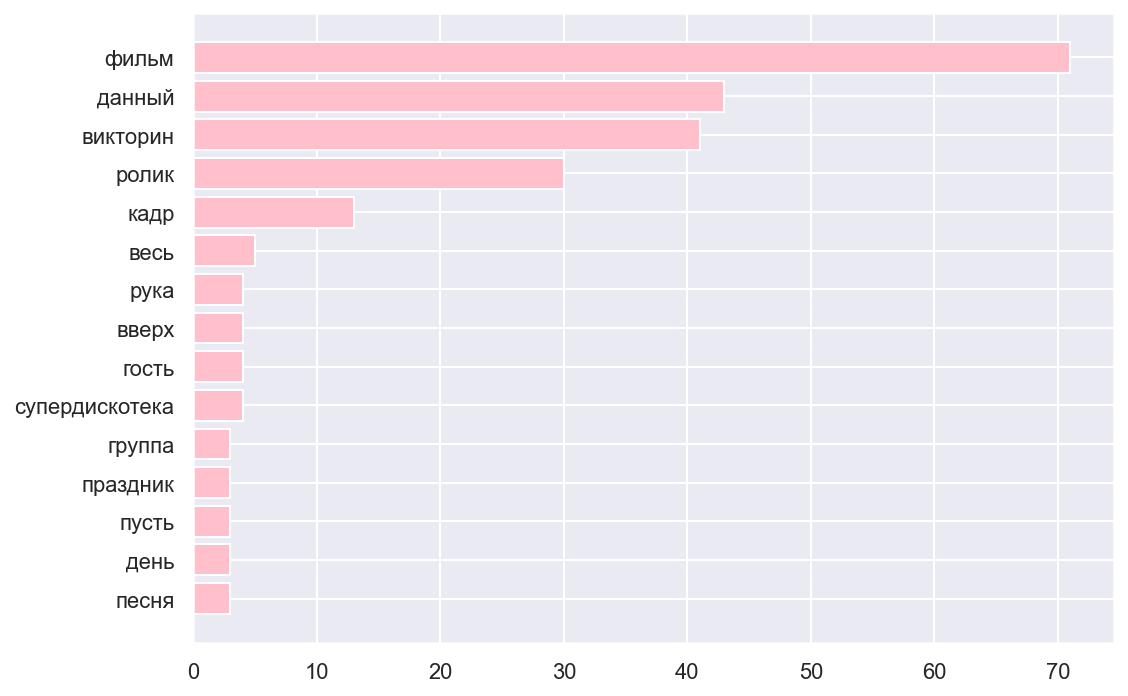

In [6]:
from collections import Counter

tokens_list = [i.split() for i in сlean_data]
counts = Counter(tokens_list[550]).most_common(15)

word, frequency = zip(*counts)
plt.figure(figsize=[8, 5])
indices = np.arange(len(counts))
plt.barh(indices, frequency, color='pink')
plt.gca().invert_yaxis()
plt.yticks(indices, word)
plt.tight_layout()
plt.show()

## TF-IDF
For further analysis we needed to implement recode the words into numbers or vectorize them. If we simply count the number of occurrence of one particular token it won't give us interpretable and high-quality results, we decided to use TF-IDF instead.
The Term Frequency of a word is the measure of how often it appears in a document, while the Inverse Document Frequency is the parameter which reduces the importance of a word if it frequently appears in several documents.
To sum up, TF-IDF enables us to find the words that are important to any given document.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df = 0.8, min_df = 0.2, use_idf = True, ngram_range = (1, 3))
tfidf_matrix = tfidf_vectorizer.fit_transform([post for post in сlean_data])

print(tfidf_matrix.shape)

(562, 1289)


## KMeans clusters
<p>To determine how closely one community is related to the other we can use clustering techniques. Clustering is the method of unsupervised learning where you can group together a number of items such that they have some similar properties. According to the measure of similarity desired, a given sample of items can have one or more clusters.

In [8]:
from sklearn.cluster import KMeans

inertia = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters = k, random_state=1).fit(tfidf_matrix)
    inertia.append(np.sqrt(kmeans.inertia_))

In [9]:
final_clus_num = 4

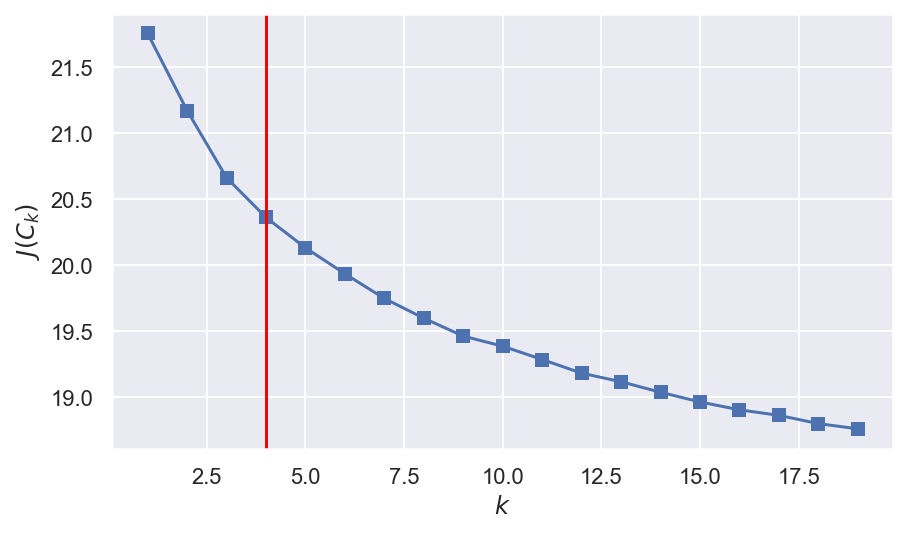

In [10]:
plt.figure(figsize = (7, 4))
plt.plot(range(1, 20), inertia, marker = 's');
plt.axvline(final_clus_num, c = 'red')
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

In [11]:
from sklearn.cluster import KMeans

# Create a KMeans object with 11 clusters and save as km
km = KMeans(n_clusters = 4)

# Fit the k-means object with tfidf_matrix
km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

posts_df = pd.DataFrame()
posts_df['cluster'] = clusters
posts_df['posts'] = posts.to_list()

# Display number of communities per cluster 
posts_df['cluster'].value_counts().to_frame().rename(columns = {'cluster' : 'community_count'}).head()

,community_count
3,221
1,130
0,111
2,100


## Post similarity

In [12]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate the similarity distance
similarity_distance = 1 - cosine_similarity(tfidf_matrix)

##  Linkage and Dendrograms
We can visualize the level of similarity between the groups using a dendrogram. Dendrograms help visualize the results of hierarchical clustering, which is an alternative to k-means clustering. We plot a dendrogram of the communities whose similarity measure will be given by the similarity distance we previously calculated. The lower the similarity distance between any two communities, the lower their linkage will make an intercept on the y-axis. However, in our case Dendrograms are difficult to interpret as we heva lots of instances. Using less groups may help.


In [13]:
from scipy.cluster.hierarchy import linkage, dendrogram 

# Create mergings matrix 
mergings =linkage(similarity_distance, method='complete')

# Plot the dendrogram, using title as label column
dendrogram_ = dendrogram(mergings,
               labels=[x for x in data['ids']],
               leaf_rotation=90,
               leaf_font_size=18,
)

# Adjust the plot
fig = plt.gcf()
_ = [lbl.set_color('r') for lbl in plt.gca().get_xmajorticklabels()]
fig.set_size_inches(108, 50)

# Show the plotted dendrogram
plt.show()


## Word Frequency in each cluster

In order to understand what each cluster represents we calculate TF-IDF for each token within a cluster and visualize it. Now we have some kind of description of each cluster and we can check the group we are interested in and compare if it is similar to the cluster it was assigned to.

In [14]:
tf_idf = pd.DataFrame(data = tfidf_matrix.toarray(), columns = tfidf_vectorizer.get_feature_names())

def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tfidf_vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

final_df_array = tf_idf.to_numpy()
prediction = posts_df['cluster']
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)

Obviously, our clustering represents different group topics. What is interesting is to compare them with other clustering methods.

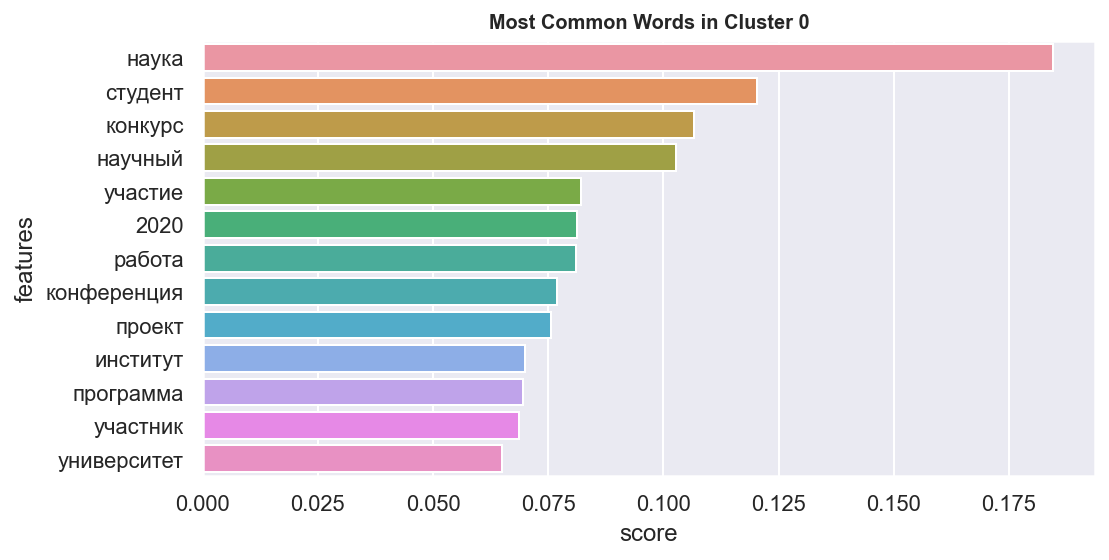

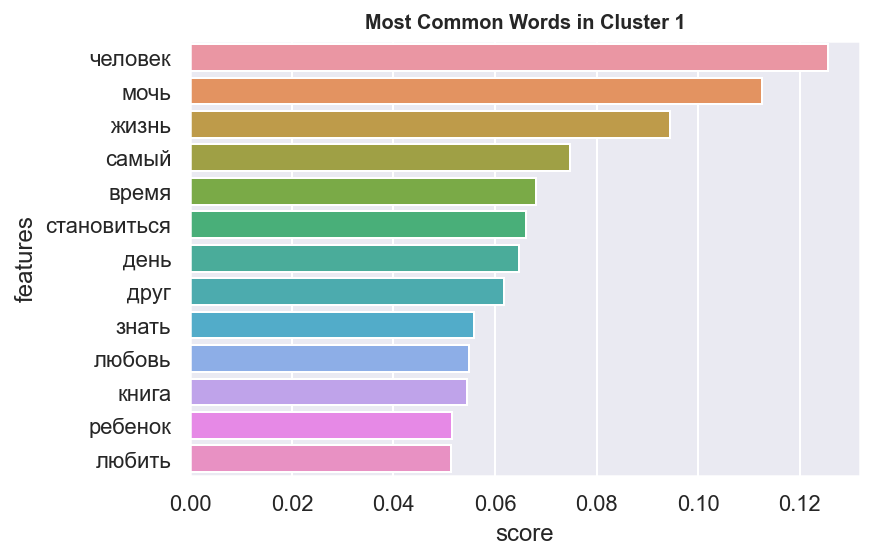

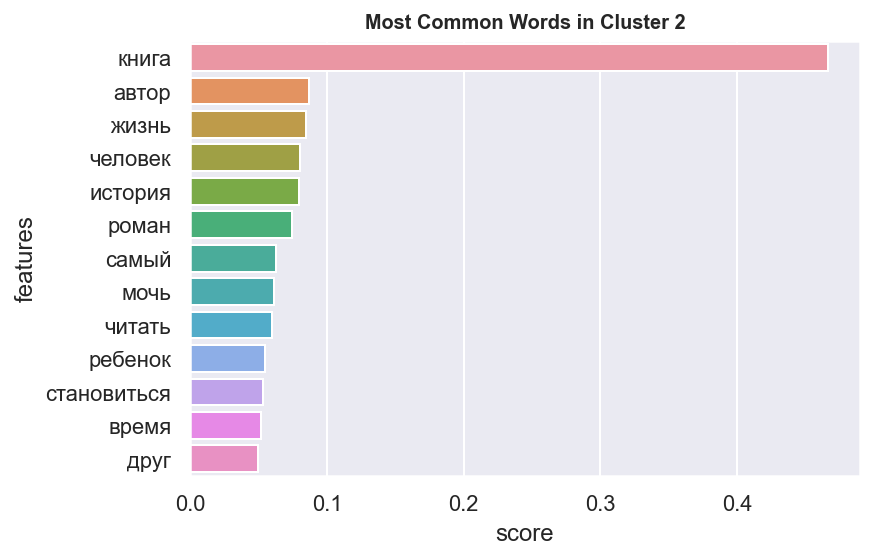

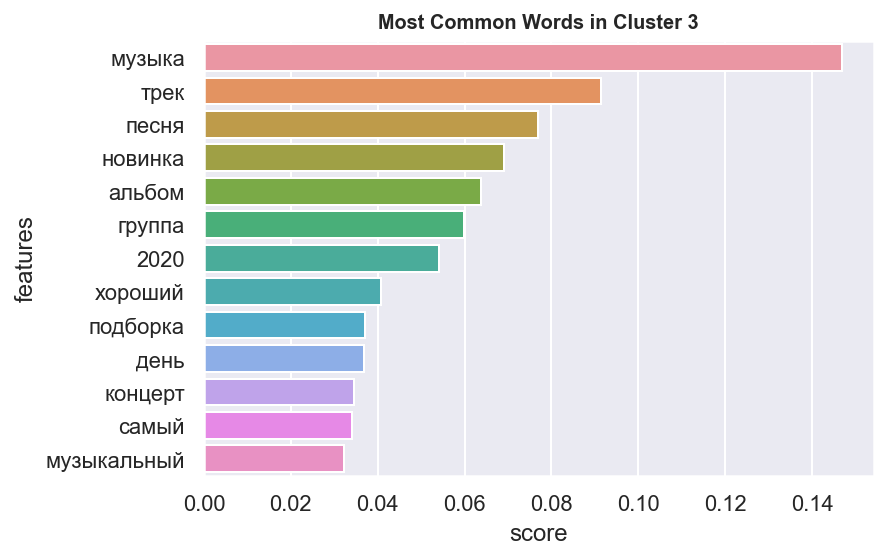

In [15]:
plotWords(dfs, 13)

# Text Preprocessing + Bert + DBSCAN

We also decided to perform the 2nd clustering using other algorithm. Bert is a neural network which is rather popular and so difficelt as there are pretrained models available. 

In [16]:
# TextDataset class for your convinience
class TextDataset(Dataset):
    def __init__(self, texts, tokenizer):
        self.texts = texts
        self.tokenizer = tokenizer

    def __getitem__(self, idx):
        return self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=128,
            return_tensors='pt',
        )

    def __len__(self):
        return len(self.texts)

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

## Importing BERT

The very first step we have to do is converting the documents to numerical data. We use BERT for this purpose as it extracts different embeddings based on the context of the word.

RuBERT was trained on the Russian part of Wikipedia and news data. We used this training data to build vocabulary of Russian subtokens and took multilingual version of BERT-base as initialization for RuBERT.


In [17]:
# model import code 
tokenizer = BertTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")
config = BertConfig.from_pretrained("DeepPavlov/rubert-base-cased")
model = BertModel.from_pretrained("DeepPavlov/rubert-base-cased", config=config)
model.to("cpu")

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
         

In [18]:
dataset = TextDataset(сlean_data, tokenizer)
loader = DataLoader(dataset, batch_size=32)

In [19]:
# get resulting vectors from given texts
vecs = []
for x in loader:
    x = {key: x[key].squeeze().to("cpu") for key in x}
    out = model(**x)
    vec = mean_pooling(out, x["attention_mask"]).cpu().tolist()
    vecs += vec

## Clustering | UMAP + DBSCAN

<p> We want to make sure that documents with similar topics are clustered together such that we can find the topics within these clusters. Before doing so, we first need to lower the dimensionality of the embeddings as many clustering algorithms handle high dimensionality poorly. <p>

In [20]:
%%time
umap_embeddings = umap.UMAP(
    n_neighbors=15, 
    n_components=5, 
    metric='cosine',
).fit_transform(vecs)

CPU times: user 9.75 s, sys: 2.23 s, total: 12 s
Wall time: 12.1 s


After having reduced the dimensionality of the documents embeddings, we can cluster the documents with HDBSCAN. HDBSCAN is a density-based algorithm that works quite well with UMAP since UMAP maintains a lot of local structure even in lower-dimensional space. Moreover, HDBSCAN does not force data points to clusters as it considers them outliers.

In [21]:
%%time
cluster = hdbscan.HDBSCAN(
    min_cluster_size=15,
    metric='euclidean',                      
    cluster_selection_method='eom',
).fit(umap_embeddings)

CPU times: user 17.5 ms, sys: 6.68 ms, total: 24.1 ms
Wall time: 46.9 ms


In [22]:
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(umap_embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

In [24]:
posts_df['dbscan_cluster'] = result['labels']

In [28]:
set(posts_df['cluster']), set(posts_df['dbscan_cluster'])

({0, 1, 2, 3}, {-1, 0, 1, 2, 3, 4})

We have an interesting circular figure on the graph that 

In [29]:
fig = go.Figure(data=go.Scatter(x=result['x'],
                                y=result['y'],
                                mode='markers',
                                marker_color = result['labels'],
                                text = result['labels'])) # hover text goes here
                                
fig.update_layout(title='Clusters by DBSCAN')
fig.show()

# Jaccard Similarity (under construction)

We wanted to check the consistency of texts clustering with followers based clustring using Jaccard index:
\begin{equation*}
\frac{|B\cap L|}{|B\cup L|},
\end{equation*}
where B - set of followers id of 1st group,
L - set of followers ids of 2nd group

In [31]:
from math import*
 
def jaccard_similarity(x,y):
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    union_cardinality = len(set.union(*[set(x), set(y)]))
    return intersection_cardinality/float(union_cardinality)

In [111]:
jaccard_df = pd.DataFrame(columns = data.ids, index = data.ids)

for i in data.ids:
    for j in data.ids:
        jaccard_df.loc[i, j] = jaccard_similarity(data.loc[data.ids == i, 'member_ids'], data.loc[data.ids == j, 'member_ids'])

In [113]:
jaccard_df.head()

ids,27737784,190320587,153252740,20393607,122045357,130930065,2187048,47764900,469769,56778367,...,3609748,29520268,28728693,62470167,172950314,111169078,136987890,1884849,20499050,159468419
ids,,,,,,,,,,,,,,,,,,,,,
27737784,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
190320587,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
153252740,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20393607,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
122045357,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# LDA

We also performed a topic modeling to characterize each cluster and compare the given cluster with the whole collection of documents. First, we are creating a dictionary from the data, then convert to bag-of-words corpus and save the dictionary and corpus for future use.



LDA is a method of unsupervised learning where the documents are treated as the bags of words. LDA works with topics and assigning words and documents to the topics using Dirichlet distribution.

In [209]:
tokens_list = [i.split() for i in сlean_data]

In [210]:
from gensim import corpora
import gensim

dictionary = corpora.Dictionary(tokens_list)
corpus = [dictionary.doc2bow(text) for text in tokens_list]

We are asking LDA to find 6 topics in the data:

In [215]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 6, id2word=dictionary, passes=15)
topics = ldamodel.print_topics(num_words=4)

In [216]:
import pyLDAvis.gensim

lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

As a result, we found out that clustering algorithm used produce different results, but are able to distinguish different topic.
For the future development we are going to parse data on group followers ids, perform Jaccard measure based clustering and identify if users follow the same interest patterns. 